In [ ]:
import torch; torch.manual_seed(0)
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torch.distributions.mixture_same_family import MixtureSameFamily
import torch.distributions as DIST
from sklearn.datasets import make_moons, make_circles, make_classification

import pandas as pd
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

import sys, os

added_path = os.path.join(os.path.abspath(".."))
if added_path not in sys.path:
    sys.path.append(added_path)
print(sys.path)

from models.toy_classifier_util import *

In [42]:
def identity_init(layers):
    for layer in layers:
        nn.init.eye_(layer.weight)
        nn.init.zeros_(layer.bias)


def plot_normal_dist(data, ax, xmin, xmax, color, name):
    data = np.array(data)

    # Fit a normal distribution to the data:
    mu, std = norm.fit(data)

    # Plot the histogram.
#     ax.hist(data, bins=num_bins, density=True, alpha=0.6, color='b')

    # Plot the PDF.
    x = np.linspace(xmin, xmax, 1000)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, color, linewidth=2, label=name)
    # ax.legend()


class ToyDataset:

    def __init__(self, num_sample, rng_seed):
        self.rng_seed = rng_seed
        self.num_samples = num_sample

    def getData(self, args, plot=False, label=False):

        if args['name'] == 'circles':
            X, y = make_circles(noise=args['noise'], n_samples=self.num_samples*2,
                                random_state=self.rng_seed, factor=args['factor'])
            X1, X2 = X[y==0], X[y==1]

        elif args['name'] == 'moon':
            X, y = make_moons(noise=args['noise'], n_samples=self.num_samples*2,
                              random_state=self.rng_seed)
            X1, X2 = X[y==0], X[y==1]

        elif args['name'] == 'rotated_moon':
            X, y = make_moons(noise=args['noise'], n_samples=self.num_samples,
                              random_state=self.rng_seed)
            X_zm = (X-np.array([0.5, 0.25]))*np.array([0.75, 1.25])
            rot_matrix = np.array([[np.cos(args['theta']), -np.sin(args['theta'])],
                                   [np.sin(args['theta']), np.cos(args['theta'])]])
            X_rot = X_zm@rot_matrix
            X1, X2 = X, X_rot+np.array([0.5, 0.25])

        elif args['name'] == 'gaussian':
            X1, X2 = torch.randn(self.num_samples, 2), torch.randn(self.num_samples, 2)

        elif args['name'] == 'random':
            X, y = make_classification(n_samples=self.num_samples,
                                       n_features=args['n_features'],
                                       n_redundant=args['n_redundant'],
                                       random_state=self.rng_seed)
            X1, X2 = X[y==0], X[y==1]


        if plot:
            plt.scatter(*X1.T)
            plt.scatter(*X2.T)
            plt.show()
        if label:
            return [torch.from_numpy(X1).type(torch.FloatTensor), torch.from_numpy(X2).type(torch.FloatTensor)], y
        else:
            return [torch.from_numpy(X1).type(torch.FloatTensor), torch.from_numpy(X2).type(torch.FloatTensor)]

    def __len__(self):
        return self.num_samples


class LinearVAUB(nn.Module):
    def __init__(self, input_features=1, latent_features=1, hidden_features=3, option="CF", learnable_loc=False, learnable_var=False, pz=None):
        super(LinearVAUB, self).__init__()

        # encoder & decoder
        self.enc1 = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=latent_features*2),
        )

        self.enc2 = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=latent_features*2),
        )

        self.dec1 = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=input_features),
        )

        self.dec2 = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.ReLU(),
            nn.Linear(in_features=hidden_features, out_features=input_features),
        )

        # identity_init(self.enc1)
        # identity_init(self.enc2)
        # identity_init(self.dec1)
        # identity_init(self.dec2)

        self.E_arr = [self.enc1, self.enc2]
        self.D_arr = [self.dec1, self.dec2]

        # shared distribution
        '''
        change this line
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        to
        '''
        self.log_scale_arr = [nn.Parameter(torch.Tensor([0.0])) for _ in range(2)]

        self.latent_loc = nn.Parameter(torch.Tensor([0.0])) if learnable_loc else torch.Tensor([0.0])
        self.latent_log_var = nn.Parameter(torch.Tensor([0.0])) if learnable_var else torch.Tensor([0.0])

        self.Recon_Loss = [[],[]]

        self.mu = None
        self.log_var = None
        self.elbo = None
        self.criterion = nn.MSELoss()

        self.option = option
        if pz:
            self.pz = pz
            self.option = "MC-PZ"


    def simulate_output(self, mean, idx):

        noise = torch.distributions.Normal(0, 1)
        return mean + noise.sample(mean.size())*0.05


    def reparameterize(self, mu, log_var):

        std = torch.exp(log_var/2).float()
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return z


    def forward(self, x_input, scale_recon=1):

        self.recon_loss = 0
        self.elbo = 0
        self.vaub=0
        self.z_arr = []
        self.x_hat_arr = []
        self.x_flipped_arr = []

        for idx in range(2):
            x_original = x_input[idx]
            x = x_input[idx]
            # encoding
            x = self.E_arr[idx](x)

            # get `mu` and `log_var`
            self.mu = x[:, 0, None] # the first feature values as mean
            self.log_var = x[:, 1, None] # the other feature values as variance

            # get the latent vector through reparameterization
            z = self.reparameterize(self.mu, self.log_var)
            self.z_arr.append(z)

            # decoding
            x_hat = self.D_arr[idx](z)
            self.x_hat_arr.append(self.simulate_output(x_hat, idx))

            # get flipped results
            x_flipped = self.D_arr[(idx+1)%2](z)
            self.x_flipped_arr.append(self.simulate_output(x_flipped,(idx+1)%2))

            if self.option == "MC":
                # reconstruction loss
                recon_loss = -1*self.gaussian_likelihood(x_hat, x_original, self.log_scale_arr[idx])
                self.Recon_Loss[idx].append(recon_loss.mean().item())

                # kl loss
                kl_loss = self.kl_divergence(z, self.mu, self.log_var)

                # elbo
                elbo = kl_loss + scale_recon*recon_loss
                vaub = kl_loss + recon_loss

            if self.option == "MC-PZ":
                # reconstruction loss
                recon_loss = -1*self.gaussian_likelihood(x_hat, x_original, self.log_scale_arr[idx])
                self.Recon_Loss[idx].append(recon_loss.mean().item())

                # kl loss
                kl_loss = self.kl_divergence_with_pz(z, self.mu, self.log_var)

                # elbo
                elbo = kl_loss + scale_recon*recon_loss
                vaub = kl_loss + recon_loss

            self.vaub += vaub.mean()
            self.recon_loss += recon_loss.mean()
            self.elbo += elbo.mean()

        return x_hat

    def kl_divergence_with_pz(self, z, mu, log_var):

        # mu = self.mu
        std = torch.exp(log_var/2)

        # p = torch.distributions.Normal(torch.zeros_like(mu)+self.latent_loc, torch.ones_like(std)*torch.exp(self.latent_log_var/2))
        # p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        # log_pz = p.log_prob(z)
        log_pz = self.pz.log_prob(z)

        kl = (log_qzx - log_pz)

        # sum over last dim to go from single dim distribution to multi-dim
        kl = kl.sum(-1)
        return kl


    def kl_divergence(self, z, mu, log_var):

        # mu = self.mu
        std = torch.exp(log_var/2)

        p = torch.distributions.Normal(torch.zeros_like(mu)+self.latent_loc, torch.ones_like(std)*torch.exp(self.latent_log_var/2))
        # p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        kl = (log_qzx - log_pz)

        # sum over last dim to go from single dim distribution to multi-dim
        kl = kl.sum(-1)
        return kl


    def gaussian_likelihood(self, x_hat, x, learnable_scale):
        scale = torch.exp(learnable_scale)
        mean = x_hat
        # print(mean.size(), scale.size())
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        # print(mean.size(), x.size())
        log_pxz = dist.log_prob(x)
        # print(log_pxz.size(), log_pxz.sum(-1).size())
        return log_pxz.sum(-1)


def train_VAUB(model, X_arr, n_epochs, lr, scale_recon, y=None, plot_in=False):

    opt = torch.optim.Adam(params=model.parameters(), lr=lr)
    n_samples = X_arr[0].shape[0]

    Loss = []
    # Loss_KL = []
    Loss_recon = []
    wd_metric = []
    mmd_metric = []
    vaub_metric = []

    for epoch in range(n_epochs):

        model.train()
        opt.zero_grad()

        x_hat = model(X_arr, scale_recon=scale_recon)
        loss = model.elbo
        loss.backward()
        opt.step()

        Loss.append(loss.item())
        Loss_recon.append(model.recon_loss.item())
        vaub_metric.append(model.vaub.item())

        if epoch%(n_epochs//50) == 0:
            sinkhorn = SinkhornDistance(eps=1e-4, max_iter=500)
            wd_metric.append((sinkhorn(VAUB.z_arr[0], VAUB.z_arr[1])/n_samples).item())

            mmd_py = MMDLoss()
            mmd_metric.append((mmd_py(VAUB.z_arr[0], VAUB.z_arr[1])).item())
            print(f"epoch {epoch}")

        if plot_in is True and epoch%(n_epochs//50) == 0:
            plt.figure()
            plt.xlim([-1.2, 2.2])
            plt.ylim([-1,1.5])
            plt.scatter(*model.x_flipped_arr[0][y==0][:numvisual].T.detach(), label="d1", c="red")
            plt.scatter(*model.x_flipped_arr[1][y==0][:numvisual].T.detach(), label="d1", c="red")
            plt.scatter(*model.x_flipped_arr[0][y==1][:numvisual].T.detach(), label="d2", c="blue")
            plt.scatter(*model.x_flipped_arr[1][y==1][:numvisual].T.detach(), label="d2", c="blue")
            plt.legend()
            plt.show()

    return (Loss, wd_metric, mmd_metric, vaub_metric), x_hat

class MoGNN(nn.Module):

    def __init__(self, n_components, input_dim, loc_init=None, scale_init=None, weight_init=None):

        super(MoGNN, self).__init__()

        if loc_init is None:
            self.loc = nn.Parameter((torch.rand(n_components, input_dim)*2-1))
        else:
            self.loc = nn.Parameter(loc_init)

        if scale_init is None:
            self.log_scale = nn.Parameter(torch.zeros(n_components, input_dim))
        else:
            self.log_scale = nn.Parameter(torch.log(scale_init))

        if weight_init is None:
            self.raw_weight = nn.Parameter(torch.ones(n_components))
        else:
            self.raw_weight = nn.Parameter(torch.log(weight_init/(1-weight_init)))

    def log_prob(self, Z):

        self.loc = self.loc.to(Z.device)
        self.log_scale = self.log_scale.to(Z.device)
        self.raw_weight = self.raw_weight.to(Z.device)

        # print(torch.sigmoid(self.raw_weight))
        mix = torch.distributions.Categorical(torch.sigmoid(self.raw_weight))
        comp = torch.distributions.Independent(torch.distributions.Normal(self.loc, torch.exp(self.log_scale)), 1)
        gmm = torch.distributions.mixture_same_family.MixtureSameFamily(mix, comp)

        return gmm.log_prob(Z)

class FixedGaussian(nn.Module):

    def __init__(self, input_dim, scale=1.0, device='cpu'):
        super(FixedGaussian, self).__init__()
        self.dist = torch.distributions.MultivariateNormal(torch.zeros(input_dim).to(device), scale_tril=torch.diag(torch.ones(input_dim)*scale).to(device))

    def log_prob(self, x):
        return self.dist.log_prob(x)

    def sample(self, n_sample):
        return self.dist.sample((n_sample,))

def gmm(weight, loc, scale):
    mix = DIST.Categorical(weight)
    comp = DIST.Normal(loc, scale)
    return MixtureSameFamily(mix, comp)


def get_gmm_data(kwargs_x0, kwargs_x1, n_sample, plot=False):

    x1 = gmm(**kwargs_x0).sample(torch.tensor([n_sample])).unsqueeze(1)
    x2 = gmm(**kwargs_x1).sample(torch.tensor([n_sample])).unsqueeze(1)

    if plot:
        x_sample = torch.linspace(-5, 5, 500)
        plt.figure()
        plt.plot(x_sample, gmm(**kwargs_x0).log_prob(x_sample).exp(), 'r', label="x0")
        plt.plot(x_sample, gmm(**kwargs_x1).log_prob(x_sample).exp(), 'b', label="x1")
        plt.legend()
        plt.show()

    return [x1.float(), x2.float()]

def plot_VAUB(X_arr, VAUB, numvisual=400):

    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax_2 = ax.twinx()
    ax_3 = ax.twinx()
    ax_4 = ax.twinx()
    tick_all = list(range(len(Loss[0])))
    tick = list(range(0, len(Loss[0]), n_epochs//50))
    ln_1 = ax.plot(Loss[0], "-r", label="Loss")
    ln_2 = ax_2.plot(tick, Loss[1], "--b", label="WD")
    ln_3 = ax_3.plot(tick, Loss[2], "-*m", label="MMD")
    ln_4 = ax_4.plot(Loss[3], "-g", label="VAUB")
    lns = ln_1+ln_2+ln_3+ln_4
    labs = [l.get_label() for l in lns]
    ax_2.get_xaxis().set_visible(False)
    ax_3.get_yaxis().set_visible(False)
    ax_4.get_yaxis().set_visible(False)
    plt.title("Different Loss/metric over training for 2D rotated moon dataset")
    ax.legend(lns, labs, loc=5)
    plt.show()

    # numvisual = 400
    plt.style.use('default')

    # fig, ax = plt.subplots(figsize=(10, 8))
    # ax.set_xlim([-1.2, 2.2])
    # ax.set_ylim([-1,1.5])
    # ax.scatter(*X_arr[0][:numvisual].T.detach(), label="x1", c='r', marker=".")
    # ax.scatter(*X_arr[1][:numvisual].T.detach(), label="x2", c='r', marker="+")
    # ax.scatter(*VAUB.x_hat_arr[0][:numvisual].T.detach(), label="x1-recon", c='b', marker=".")
    # ax.scatter(*VAUB.x_hat_arr[1][:numvisual].T.detach(), label="x2-recon", c='b', marker="+")
    # ax.legend(fontsize=15)
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    # plt.show()
    #
    # fig, ax = plt.subplots(figsize=(10, 8))
    # ax.set_xlim([-1.2, 2.2])
    # ax.set_ylim([-1,1.5])
    # ax.scatter(*X_arr[0][:numvisual].T.detach(), label="x1", c='r', marker=".")
    # ax.scatter(*X_arr[1][:numvisual].T.detach(), label="x2", c='r', marker="+")
    # ax.scatter(*VAUB.x_flipped_arr[0][:numvisual].T.detach(), label="x1-fliped", c='b', marker=".")
    # ax.scatter(*VAUB.x_flipped_arr[1][:numvisual].T.detach(), label="x2-fliped", c='b', marker="+")
    # ax.legend(fontsize=15)
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim([-1.2, 2.2])
    ax.set_ylim([-1,1.5])
    ax.scatter(*X_arr[0][:numvisual].T.detach(), label="x1", c='b', marker=".")
    ax.scatter(*X_arr[1][:numvisual].T.detach(), label="x2", c='r', marker="+")
    ax.legend(fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim([-1.2, 2.2])
    ax.set_ylim([-1,1.5])
    ax.scatter(*VAUB.x_hat_arr[0][:numvisual].T.detach(), label="x1-recon", c='b', marker=".")
    ax.scatter(*VAUB.x_hat_arr[1][:numvisual].T.detach(), label="x2-recon", c='r', marker="+")
    ax.legend(fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim([-1.2, 2.2])
    ax.set_ylim([-1,1.5])
    ax.scatter(*VAUB.x_flipped_arr[0][:numvisual].T.detach(), label="x1-fliped", c='b', marker=".")
    ax.scatter(*VAUB.x_flipped_arr[1][:numvisual].T.detach(), label="x2-fliped", c='r', marker="+")
    ax.legend(fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    # plt.figure(figsize=(10, 8))
    # plt.xlim([-1.2, 2.2])
    # plt.ylim([-1,1.5])
    # plt.scatter(*X_arr[0][:numvisual].T.detach(), label="x1")
    # plt.scatter(*X_arr[1][:numvisual].T.detach(), label="x2")
    # plt.scatter(*VAUB.x_flipped_arr[0][:numvisual].T.detach(), label="x2-fliped")
    # plt.scatter(*VAUB.x_flipped_arr[1][:numvisual].T.detach(), label="x1-fliped")
    # plt.legend()
    # plt.show()


    x_sample = torch.linspace(-5, 6, 500)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax_2 = ax.twinx()
    ax.set_ylim([0, 0.3])
    ax_2.set_ylim([0, 0.15])
    ax_2.get_yaxis().set_visible(False)
    # ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.plot(x_sample, VAUB.pz.log_prob(x_sample.unsqueeze(1)).exp().detach().numpy(), '--r', label="pz")
    ax.legend(loc="upper left", fontsize=15)

    dataset = pd.DataFrame({
            "z0": VAUB.z_arr[0].detach().numpy().ravel(),
            "z1": VAUB.z_arr[1].detach().numpy().ravel(),
    }, np.arange(len(VAUB.z_arr[0])))
    sns.set(font_scale=1.5)
    gfg = sns.histplot(data=dataset, stat='density', kde=False, ax=ax_2, legend=True)
    # gfg.legend(fontsize=15)
    plt.show()

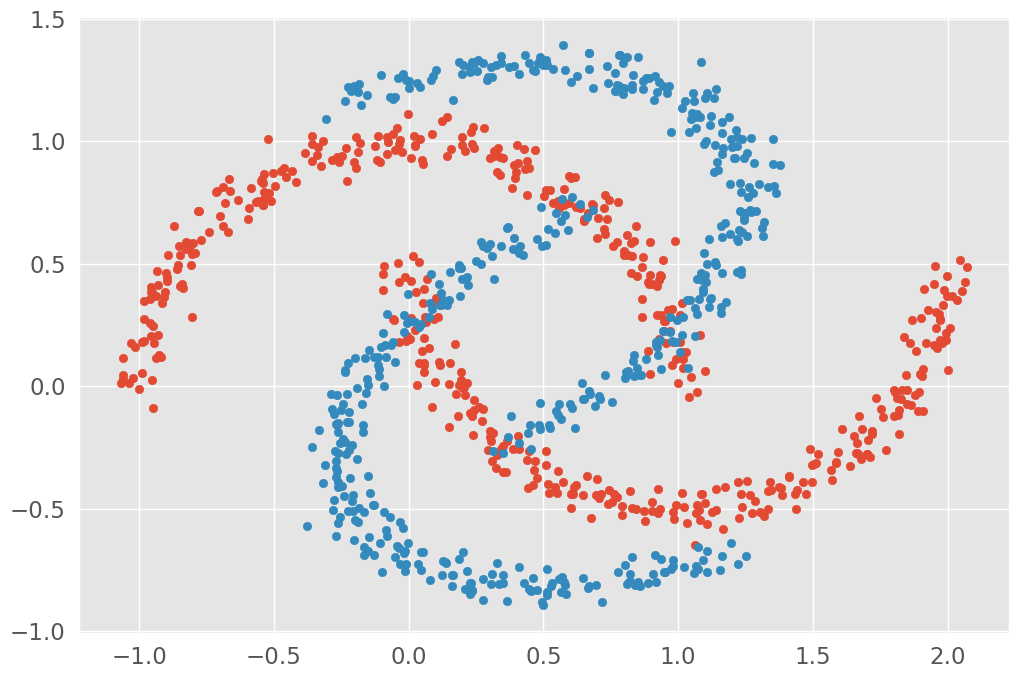

In [43]:
data = {'name':'rotated_moon', 'noise':0.05, 'theta':np.pi*3/8}
demo_data = ToyDataset(num_sample=500, rng_seed=0)
X_arr = demo_data.getData(data, plot=True)

In [6]:
# ############################################
# #####     Training hyperparameters     #####
# ############################################
# data = {'name':'moon', 'noise':0.05}
# n_epochs = 2000
# lr = 1e-2
# input_features = 2
# hidden_features = 20
# latent_features = 1
# N = int(1e3)
# scale_recon = 1e4
# # learnable_loc, learnable_var = True, True
# vae_option = "MC-PZ"
#
# kwargs_pz = {
#     "n_components": 10,
#     "input_dim": 1,
#     }
#
# kwargs_train = {
#     "n_epochs": n_epochs,
#     "lr": lr,
#     "scale_recon": scale_recon,
# }
#
# demo_data = ToyDataset(num_sample=N, rng_seed=0)
#
# ############################################
# #####         Training models          #####
# ############################################
# pz = MoGNN(**kwargs_pz)
#
# VAUB = LinearVAUB(input_features=input_features,
#                   hidden_features=hidden_features,
#                   latent_features=latent_features,
#                   option = vae_option,
#                   pz=pz,
#                   )
#
# ############################################
# #####          Training data           #####
# ############################################
# X_arr = demo_data.getData(data, plot=True)
#
# ############################################
# #####        Training script           #####
# ############################################
# Loss, vaub = train_VAUB(VAUB, X_arr, **kwargs_train)

In [7]:
# ############################################
# #####       Visulizing script          #####
# ############################################
# # plt.figure()
# # plt.plot(Loss)
# # plt.show()
# numvisual = 200
#
# plt.figure()
# plt.xlim([-1.5, 2.5])
# plt.ylim([-1,1.5])
# plt.scatter(*X_arr[0][:numvisual].T.detach(), label="x1")
# plt.scatter(*X_arr[1][:numvisual].T.detach(), label="x2")
# plt.scatter(*VAUB.x_hat_arr[0][:numvisual].T.detach(), label="reconstructed x1")
# plt.scatter(*VAUB.x_hat_arr[1][:numvisual].T.detach(), label="reconstructed x2")
# plt.legend()
# plt.show()
#
# plt.figure()
# plt.xlim([-1.5, 2.5])
# plt.ylim([-1,1.5])
# plt.scatter(*X_arr[0][:numvisual].T.detach(), label="x1")
# plt.scatter(*X_arr[1][:numvisual].T.detach(), label="x2")
# plt.scatter(*VAUB.x_flipped_arr[0][:numvisual].T.detach(), label="transformed x2")
# plt.scatter(*VAUB.x_flipped_arr[1][:numvisual].T.detach(), label="transformed x1")
# plt.legend()
# plt.show()
#
#
# x_sample = torch.linspace(-4, 4.5, 500)
# fig, ax = plt.subplots(figsize=(15, 8))
# ax_2 = ax.twinx()
# ax.set_ylim([0, 0.4])
# ax_2.set_ylim([0, 0.2])
# ax_2.get_yaxis().set_visible(False)
#
# ax.plot(x_sample, VAUB.pz.log_prob(x_sample.unsqueeze(1)).exp().detach().numpy(), '--r', label="pz")
# ax.legend(loc="upper left")
#
# dataset = pd.DataFrame({
#         "z0": VAUB.z_arr[0].detach().numpy().ravel(),
#         "z1": VAUB.z_arr[1].detach().numpy().ravel(),
# }, np.arange(len(VAUB.z_arr[0])))
# sns.histplot(data=dataset, stat='density', kde=False, ax=ax_2, legend=True)
#
# plt.show()

epoch 0
epoch 16
epoch 32
epoch 48
epoch 64
epoch 80
epoch 96
epoch 112
epoch 128
epoch 144
epoch 160
epoch 176
epoch 192
epoch 208
epoch 224
epoch 240
epoch 256
epoch 272
epoch 288
epoch 304
epoch 320
epoch 336
epoch 352
epoch 368
epoch 384
epoch 400
epoch 416
epoch 432
epoch 448
epoch 464
epoch 480
epoch 496
epoch 512
epoch 528
epoch 544
epoch 560
epoch 576
epoch 592
epoch 608
epoch 624
epoch 640
epoch 656
epoch 672
epoch 688
epoch 704
epoch 720
epoch 736
epoch 752
epoch 768
epoch 784


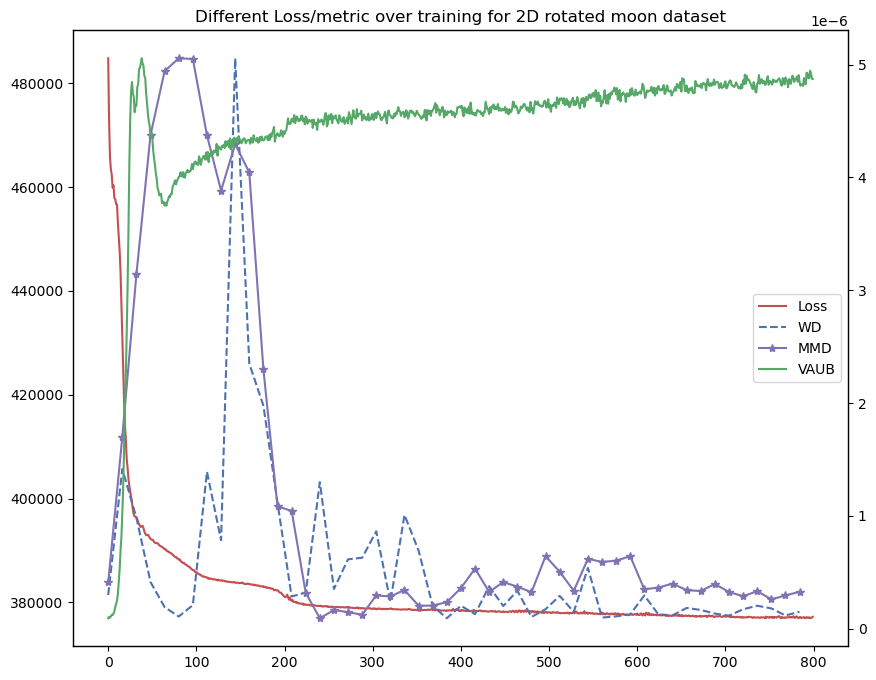

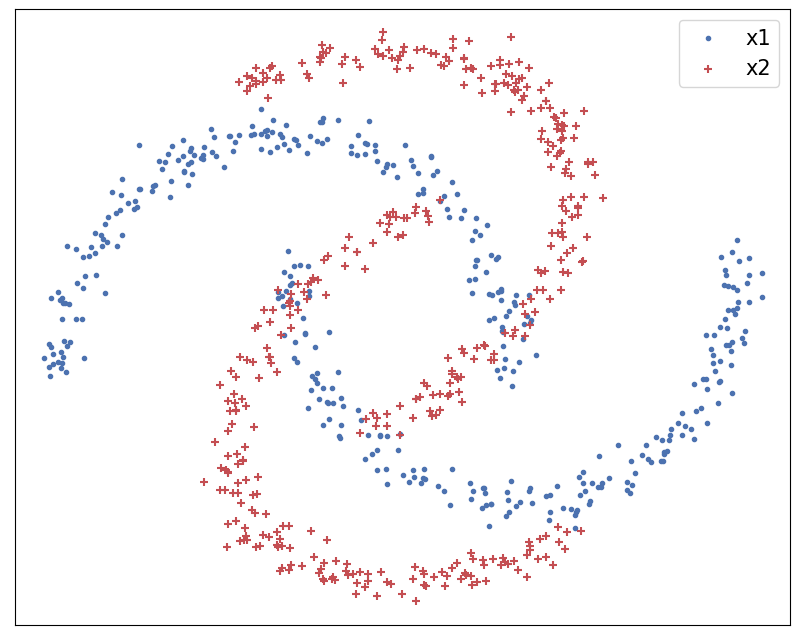

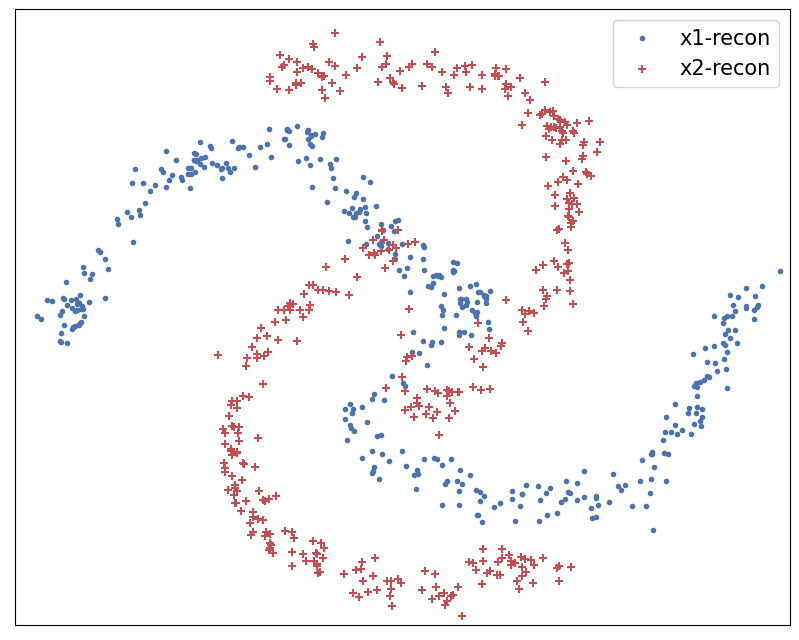

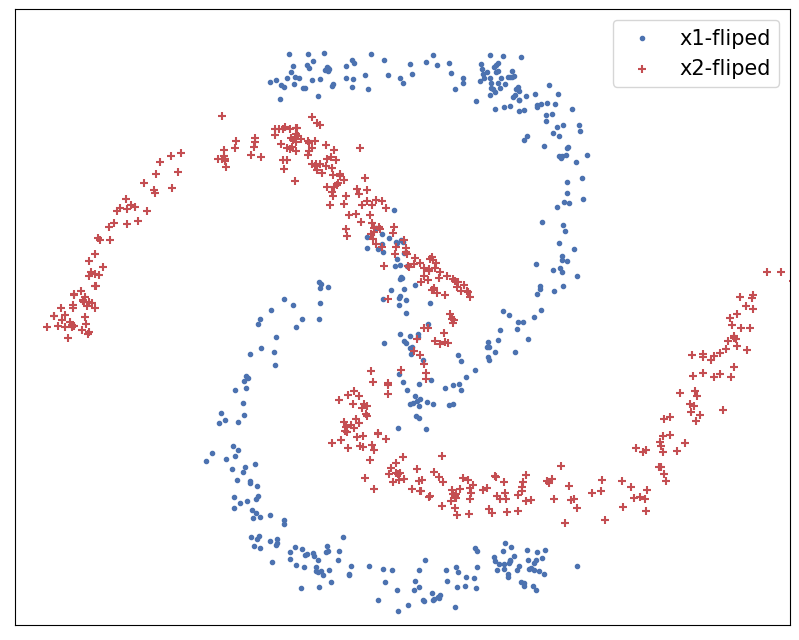

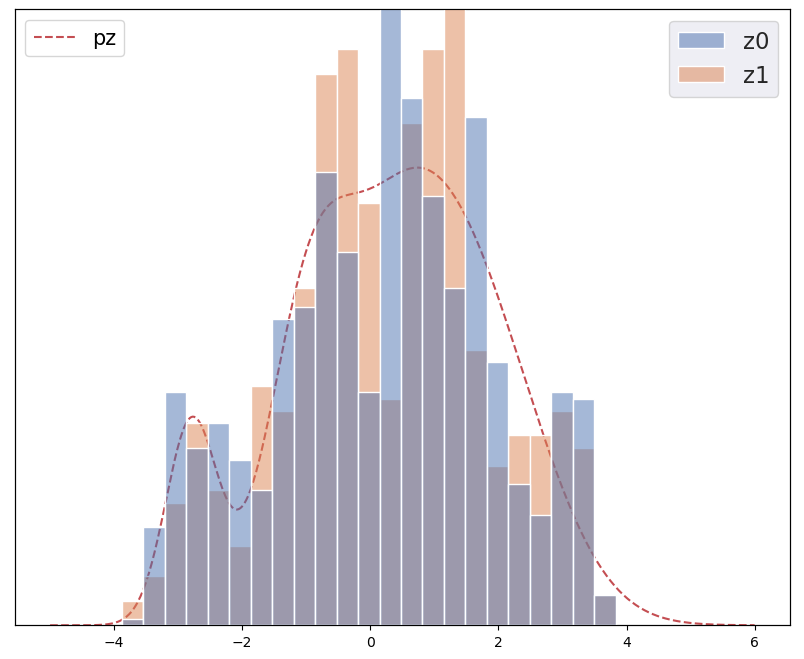

In [44]:
############################################
#####     Training hyperparameters     #####
############################################
data = {'name':'rotated_moon', 'noise':0.05, 'theta':np.pi*3/8}
n_epochs = 800
lr = 1e-2
input_features = 2
hidden_features = 20
latent_features = 1
N = int(1e3)
scale_recon = 1e5
# learnable_loc, learnable_var = True, True
vae_option = "MC-PZ"

kwargs_pz = {
    "n_components": 10,
    "input_dim": 1,
    }

kwargs_train = {
    "n_epochs": n_epochs,
    "lr": lr,
    "scale_recon": scale_recon,
}

demo_data = ToyDataset(num_sample=N, rng_seed=0)

############################################
#####         Training models          #####
############################################
pz = MoGNN(**kwargs_pz)

VAUB = LinearVAUB(input_features=input_features,
                  hidden_features=hidden_features,
                  latent_features=latent_features,
                  option = vae_option,
                  pz=pz,
                  )

############################################
#####          Training data           #####
############################################
X_arr, y = demo_data.getData(data, plot=False, label=True)

############################################
#####        Training script           #####
############################################
Loss, vaub = train_VAUB(VAUB, X_arr, **kwargs_train, y=y, plot_in=False)

############################################
#####       Visulizing script          #####
############################################
plot_VAUB(X_arr, VAUB, numvisual=400)